In [0]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s "/content/drive/My Drive/data" "/content/data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import nltk
import re
from collections import Counter
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Embedding, Dense, Input, Concatenate, TimeDistributed, Bidirectional
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from tensorflow.python.keras.utils.vis_utils import plot_model
from sklearn import preprocessing
from tensorflow.python.keras import regularizers
import tensorflow as tf
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.regularizers import l2          
from bs4 import BeautifulSoup 
from tensorflow.python.keras.preprocessing.text import Tokenizer 
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
data=pd.read_csv(r'/content/data/clustered_review_df.csv')
data

In [0]:
data.drop_duplicates(subset=['Merged_Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na
data = data.sample(frac=1).reset_index(drop=True)
data

In [0]:
data = data.head(100000)

In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}


In [0]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [0]:
cleaned_text = []
for t in data['Merged_Text']:
    cleaned_text.append(text_cleaner(t))

In [0]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

In [0]:
cleaned_summary_1 = []
for t in data['Summary_1']:
    cleaned_summary_1.append(summary_cleaner(t))

In [0]:
cleaned_summary_2 = []
for t in data['Summary_2']:
  cleaned_summary_2.append(summary_cleaner(t))

In [0]:
data['cleaned_text']=cleaned_text
data['cleaned_summary_1']=cleaned_summary_1
data['cleaned_summary_1'].replace('', np.nan, inplace=True)
data['cleaned_summary_2']=cleaned_summary_2
data['cleaned_summary_2'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [0]:
data['cleaned_summary_1'] = data['cleaned_summary_1'].apply(lambda x : '_START_ '+ x + ' _END_')
data['cleaned_summary_2'] = data['cleaned_summary_2'].apply(lambda x : '_START_' + x + ' _END_')

In [0]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary_1:",data['cleaned_summary_1'][i])
    print("Summary_2:",data['cleaned_summary_2'][i])
    print("\n")

Review: cinnamon cake loaf wonderful natural flavor moist tender great little sweet treat want something terribly bad diet delicious year old male cat chronic urinary tract infections feed dry food combination wet food uri ease combination seems keeps uti control switch another type dry food uti gets worse cats seem enjoy food well expensive seems best solution
Summary_1: _START_ delicious  _END_
Summary_2: _START_good for feline uti  _END_


Review: taste really good purchasing different brand similar taste texture agree reviewer regarding ordering summer insulating packaging ice packs melt warm weather like chocolate food items order cold weather buy enough last yahoo deems give give suck review stuff like taste feel must assert matters taste gustibus non disputandem est really love gum really taste like strawberry still delicious wonderfully smooth consistency halfway gets tired stuff squeaky forgive squeaks perhaps find stuff wonderful dietetic aid obsessively chewing product fille

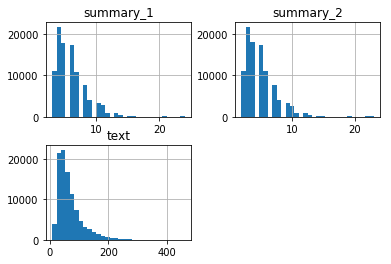

In [0]:
text_word_count = []
summary_word_count_1 = []
summary_word_count_2 = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary_1']:
      summary_word_count_1.append(len(i.split()))
    
for i in data['cleaned_summary_2']:
      summary_word_count_2.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary_1':summary_word_count_1, 'summary_2':summary_word_count_2})
length_df.hist(bins = 30)
plt.show()

In [0]:
max_len_text=200 
max_len_summary_1=10
max_len_summary_2=10

In [0]:
x_tr,x_val,y_tr_1,y_val_1,y_tr_2,y_val_2=train_test_split(data['cleaned_text'],data['cleaned_summary_1'],data['cleaned_summary_2'],
                                       test_size=0.1,random_state=0,shuffle=True) 

In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [0]:
#preparing a tokenizer for summary on training data 
y_tokenizer_1 = Tokenizer()
y_tokenizer_1.fit_on_texts(list(y_tr_1))

#convert summary sequences into integer sequences
y_tr_1    =   y_tokenizer_1.texts_to_sequences(y_tr_1) 
y_val_1   =   y_tokenizer_1.texts_to_sequences(y_val_1) 

#padding zero upto maximum length
y_tr_1    =   pad_sequences(y_tr_1, maxlen=max_len_summary_1, padding='post')
y_val_1   =   pad_sequences(y_val_1, maxlen=max_len_summary_1, padding='post')

y_voc_size_1  =   len(y_tokenizer_1.word_index) +1

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py", line 3722, in <genexpr>
    for ta, input_ in zip(input_ta, flatted_inputs))  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_should_use.py", line 193, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs))
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py", line 3722, in <genexpr>
    for ta, input_ in zip(input_ta, flatted_inputs))  File "/usr/local/lib/python3.6/dist-pa

In [0]:
#preparing a tokenizer for summary on training data 
y_tokenizer_2 = Tokenizer()
y_tokenizer_2.fit_on_texts(list(y_tr_2))

#convert summary sequences into integer sequences
y_tr_2    =   y_tokenizer_2.texts_to_sequences(y_tr_2) 
y_val_2   =   y_tokenizer_2.texts_to_sequences(y_val_2) 

#padding zero upto maximum length
y_tr_2    =   pad_sequences(y_tr_2, maxlen=max_len_summary_2, padding='post')
y_val_2   =   pad_sequences(y_val_2, maxlen=max_len_summary_2, padding='post')

y_voc_size_2  =   len(y_tokenizer_2.word_index) +1

In [0]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=True):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = 200, 500
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        print(encoder_out_seq.shape[-1])
        print(encoder_out_seq.shape[1])
        fake_state_c = create_inital_state(encoder_out_seq, 500)
        fake_state_e = create_inital_state(encoder_out_seq, 200)  # <= (batch_size, enc_seq_len, latent_dim


        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [0]:
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

#Attention Layer 1
attn_layer = AttentionLayer(name='attention_layer')

# Set up the decoder. 
decoder_inputs_1 = Input(shape=(None,)) 
dec_emb_layer_1 = Embedding(y_voc_size_1, latent_dim,trainable=True) 
dec_emb_1 = dec_emb_layer_1(decoder_inputs_1) 

#LSTM using encoder_states as initial state
decoder_lstm_1 = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs_1,decoder_fwd_state_1, decoder_back_state_1 = decoder_lstm_1(dec_emb_1,initial_state=[state_h, state_c]) 

attn_out_1, attn_states_1 = attn_layer([encoder_outputs, decoder_outputs_1]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input_1 = Concatenate(axis=-1, name='concat_layer_1')([decoder_outputs_1, attn_out_1])

#Dense layer
decoder_dense_1 = TimeDistributed(Dense(y_voc_size_1, activation='softmax')) 
decoder_outputs_1 = decoder_dense_1(decoder_concat_input_1) 


# Set up the decoder. 
decoder_inputs_2 = Input(shape=(None,)) 
dec_emb_layer_2 = Embedding(y_voc_size_2, latent_dim,trainable=True) 
dec_emb_2 = dec_emb_layer_2(decoder_inputs_2) 

#LSTM using encoder_states as initial state
decoder_lstm_2 = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs_2,decoder_fwd_state_2, decoder_back_state_2 = decoder_lstm_2(dec_emb_2,initial_state=[state_h, state_c]) 

attn_out_2, attn_states_2 = attn_layer([encoder_outputs, decoder_outputs_2]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input_2 = Concatenate(axis=-1, name='concat_layer_2')([decoder_outputs_2, attn_out_2])

#Dense layer
decoder_dense_2 = TimeDistributed(Dense(y_voc_size_2, activation='softmax')) 
decoder_outputs_2 = decoder_dense_2(decoder_concat_input_2)

# Define the model
model = Model([encoder_inputs, decoder_inputs_1, decoder_inputs_2], [decoder_outputs_1, decoder_outputs_2]) 
model.summary()

encoder_out_seq> (?, 200, 500)
decoder_out_seq> (?, ?, 500)
500
200
wa.s> (?, 200, 500)
Ua.h> (?, 1, 500)
Ws+Uh> (?, 500)
ei> (?, 200)
wa.s> (?, 200, 500)
Ua.h> (?, 1, 500)
Ws+Uh> (?, 500)
ei> (?, 200)
ci> (?, 500)
ci> (?, 500)
encoder_out_seq> (?, 200, 500)
decoder_out_seq> (?, ?, 500)
500
200
wa.s> (?, 200, 500)
Ua.h> (?, 1, 500)
Ws+Uh> (?, 500)
ei> (?, 200)
wa.s> (?, 200, 500)
Ua.h> (?, 1, 500)
Ws+Uh> (?, 500)
ei> (?, 200)
ci> (?, 500)
ci> (?, 500)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 500)     2726000     input_1[0][0]                    
__________________________________

In [0]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder 1 inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h_1 = Input(shape=(latent_dim,))
decoder_state_input_c_1 = Input(shape=(latent_dim,))
decoder_hidden_state_input_1 = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb_inf_1= dec_emb_layer_1(decoder_inputs_1)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs_inf_1, state_h_inf_1, state_c_inf_1 = decoder_lstm_1(dec_emb_inf_1, initial_state=[decoder_state_input_h_1, decoder_state_input_c_1])

#attention inference
attn_out_inf_1, attn_states_inf_1 = attn_layer([decoder_hidden_state_input_1, decoder_outputs_inf_1])
decoder_inf_concat_1 = Concatenate(axis=-1, name='concat_1')([decoder_outputs_inf_1, attn_out_inf_1])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs_inf_1 = decoder_dense_1(decoder_inf_concat_1)

# Final decoder model
decoder_model_1 = Model(
[decoder_inputs_1] + [decoder_hidden_state_input_1,decoder_state_input_h_1, decoder_state_input_c_1],
[decoder_outputs_inf_1] + [state_h_inf_1, state_c_inf_1])


# decoder 2 inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h_2 = Input(shape=(latent_dim,))
decoder_state_input_c_2 = Input(shape=(latent_dim,))
decoder_hidden_state_input_2 = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb_inf_2= dec_emb_layer_2(decoder_inputs_2)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs_inf_2, state_h_inf_2, state_c_inf_2 = decoder_lstm_2(dec_emb_inf_2, initial_state=[decoder_state_input_h_2, decoder_state_input_c_2])

#attention inference
attn_out_inf_2, attn_states_inf_2 = attn_layer([decoder_hidden_state_input_2, decoder_outputs_inf_2])
decoder_inf_concat_2 = Concatenate(axis=-1, name='concat_2')([decoder_outputs_inf_2, attn_out_inf_2])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs_inf_2 = decoder_dense_2(decoder_inf_concat_2)

# Final decoder model
decoder_model_2 = Model(
[decoder_inputs_2] + [decoder_hidden_state_input_2,decoder_state_input_h_2, decoder_state_input_c_2],
[decoder_outputs_inf_2] + [state_h_inf_2, state_c_inf_2])

encoder_out_seq> (?, 200, 500)
decoder_out_seq> (?, ?, 500)
500
200
wa.s> (?, 200, 500)
Ua.h> (?, 1, 500)
Ws+Uh> (?, 500)
ei> (?, 200)
wa.s> (?, 200, 500)
Ua.h> (?, 1, 500)
Ws+Uh> (?, 500)
ei> (?, 200)
ci> (?, 500)
ci> (?, 500)
encoder_out_seq> (?, 200, 500)
decoder_out_seq> (?, ?, 500)
500
200
wa.s> (?, 200, 500)
Ua.h> (?, 1, 500)
Ws+Uh> (?, 500)
ei> (?, 200)
wa.s> (?, 200, 500)
Ua.h> (?, 1, 500)
Ws+Uh> (?, 500)
ei> (?, 200)
ci> (?, 500)
ci> (?, 500)


In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [0]:
history=model.fit([x_tr,y_tr_1[:,:-1],y_tr_2[:,:-1]], [y_tr_1.reshape(y_tr_1.shape[0],y_tr_1.shape[1], 1)[:,1:], 
                                                       y_tr_2.reshape(y_tr_2.shape[0],y_tr_2.shape[1], 1)[:,1:]],
                  epochs=1,callbacks=[es],batch_size=64, 
                  validation_data=([x_val,y_val_1[:,:-1],y_val_2[:,:-1]], [y_val_1.reshape(y_val_1.shape[0],y_val_1.shape[1], 1)[:,1:],
                                                                          y_val_2.reshape(y_val_2.shape[0],y_val_2.shape[1], 1)[:,1:]]))

Train on 89642 samples, validate on 9961 samples
89642/89642 [==============================] - 3133s 35ms/sample - loss: 1.7946 - time_distributed_loss: 0.8554 - time_distributed_1_loss: 0.9388 - val_loss: 0.0752 - val_time_distributed_loss: 0.0260 - val_time_distributed_1_loss: 0.0492


In [0]:
model.save_weights('Multi-opinion-Summarisation.h5')

In [0]:
reverse_target_word_index_1=y_tokenizer_1.index_word 
reverse_target_word_index_2=y_tokenizer_2.index_word
reverse_source_word_index=x_tokenizer.index_word 
target_word_index_1=y_tokenizer_1.word_index
target_word_index_2=y_tokenizer_2.word_index

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index_1['start']

    stop_condition = False
    decoded_sentence_1 = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model_1.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if(sampled_token_index == 0):
          sampled_token = reverse_target_word_index_1[sampled_token_index+1]
        else:
          sampled_token = reverse_target_word_index_1[sampled_token_index]
        if(sampled_token!='end'):
            decoded_sentence_1 += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence_1.split()) >= (max_len_summary_1-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c
    
    
    #Decoder Model 2 predict
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index_2['start']

    stop_condition = False
    decoded_sentence_2 = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model_2.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if(sampled_token_index == 0):
          sampled_token = reverse_target_word_index_2[sampled_token_index+1]
        else:
          sampled_token = reverse_target_word_index_2[sampled_token_index]
        if(sampled_token!='end'):
            decoded_sentence_2 += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence_2.split()) >= (max_len_summary_2-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence_1, decoded_sentence_2

In [0]:
def seq2summary(input_seq_1, input_seq_2):
    newString_1=''
    newString_2=''
    for i in input_seq_1:
      if((i!=0 and i!=target_word_index_1['start']) and i!=target_word_index_1['end']):
        newString_1=newString_1+reverse_target_word_index_1[i]+' '
    for i in input_seq_2:
      if((i!=0 and i!=target_word_index_2['start']) and i!=target_word_index_2['end']):
        newString_2=newString_2+reverse_target_word_index_2[i]+' '
    return newString_1, newString_2

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [0]:
for i in range(len(x_val)):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val_1[i],y_val_2[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: chips good could stop eating last long reason gave stars instead think bags little hard open sure need make potato chip bag sturdy may need scissors hand open much easier tea tin guarding aroma well taste beautiful malva flowers soften taste amount bergamot right first time used much tea soaked long since save quantity tea leaves soak tea two minutes delight best earl grey ever price competitive 
Original summary: ('these are very good ', 'great well balanced earl grey ')
Predicted summary: (' these are very good', ' great well balanced earl grey')


Review: like thick chips trans fat natural according info bag flavor subjective thing bags keep eating much one time set limit bag cons another reviewer said lot oil chips place paper napkin plate pour chips wait mins eating napkin soak oil seems gross much oil chip napkin soak true least way get rid oil product received advertised twizzlers strawberry ounce bags 
Original summary: ('excellent ', 'twizzlers strawberry ')
Predicted 

KeyboardInterrupt: ignored

In [0]:
model.save_weights('Attention_Model_PDS_Amazon_Review.h5')